In [18]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [12]:
# get names of files in train_data folder

train_data_files = os.listdir("train_data")

X_train = []
y_train = []

for filename in train_data_files:
    with open("train_data/"+filename, 'r') as f:
        df = pd.read_csv(f)
        df.aX = df.aX.apply(lambda x: (x + 4) / 8)
        df.aY = df.aY.apply(lambda x: (x + 4) / 8)
        df.aZ = df.aZ.apply(lambda x: (x + 4) / 8)
        df.gX = df.gX.apply(lambda x: (x + 2000) / 4000)
        df.gY = df.gY.apply(lambda x: (x + 2000) / 4000)
        df.gZ = df.gZ.apply(lambda x: (x + 2000) / 4000)

        X_train.append(df.to_numpy())
        y_train.append(int(filename[0]))
        # plt.plot(index, df['aX'], 'g.', label='x', linestyle='solid')
        # plt.plot(index, df['aY'], 'b.', label='y', linestyle='solid')
        # plt.plot(index, df['aZ'], 'r.', label='z', linestyle='solid')
        # plt.title("Acceleration")
        # plt.xlabel("Sample #")
        # plt.ylabel("Acceleration (G)")
        # plt.legend()
        # plt.show()

In [13]:
# Convert to numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)

In [14]:
from tensorflow.keras.layers import Dense, Dropout, Input, Conv2D, Reshape, Flatten
from tensorflow.keras.models import Model

In [15]:
inputs = Input(shape=(357, 6))
x = Reshape((6, 357, 1))(inputs)
x = Conv2D(2, 3, activation='relu')(x)
x = Conv2D(2, 3, activation='relu')(x)
x = Flatten()(x)
x = Dense(16, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(inputs=inputs, outputs=x)

model.compile(optimizer='adam',
              loss='binary_crossentropy',
               metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 357, 6)]          0         
                                                                 
 reshape (Reshape)           (None, 6, 357, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 4, 355, 2)         20        
                                                                 
 conv2d_1 (Conv2D)           (None, 2, 353, 2)         38        
                                                                 
 flatten (Flatten)           (None, 1412)              0         
                                                                 
 dense (Dense)               (None, 16)                22608     
                                                                 
 dropout (Dropout)           (None, 16)                0     

2022-01-17 23:42:15.060795: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [16]:
history = model.fit(X_train, y_train, epochs=100, batch_size=32)

Epoch 1/100
1/1 [==============================] - 1s 537ms/step - loss: 0.6928 - accuracy: 0.4286
Epoch 2/100
1/1 [==============================] - 0s 5ms/step - loss: 0.6750 - accuracy: 0.8571
Epoch 3/100
1/1 [==============================] - 0s 4ms/step - loss: 0.6733 - accuracy: 1.0000
Epoch 4/100
1/1 [==============================] - 0s 5ms/step - loss: 0.6514 - accuracy: 0.8571
Epoch 5/100
1/1 [==============================] - 0s 5ms/step - loss: 0.6500 - accuracy: 1.0000
Epoch 6/100
1/1 [==============================] - 0s 4ms/step - loss: 0.6272 - accuracy: 1.0000
Epoch 7/100
1/1 [==============================] - 0s 5ms/step - loss: 0.6304 - accuracy: 1.0000
Epoch 8/100
1/1 [==============================] - 0s 5ms/step - loss: 0.6248 - accuracy: 1.0000
Epoch 9/100
1/1 [==============================] - 0s 5ms/step - loss: 0.6339 - accuracy: 1.0000
Epoch 10/100
1/1 [==============================] - 0s 5ms/step - loss: 0.5846 - accuracy: 1.0000
Epoch 11/100
1/1 [=========

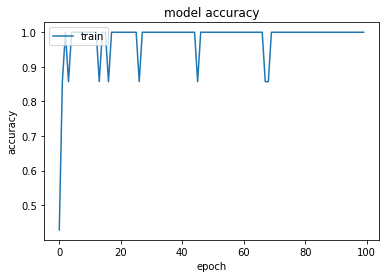

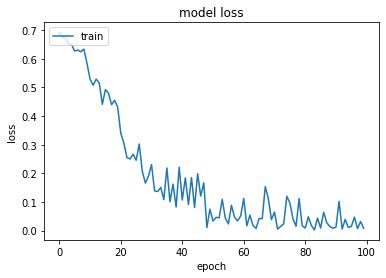

In [19]:
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Save Model using TF Lite

In [20]:
from tensorflow import lite

batch_size = 2
input_shape = model.inputs[0].shape.as_list()
input_shape[0] = batch_size
func = tf.function(model).get_concrete_function(
    tf.TensorSpec(input_shape, model.inputs[0].dtype))
converter = tf.lite.TFLiteConverter.from_concrete_functions([func])

tflite_model = converter.convert()

tfmodel = converter.convert()

# Save the model to disk
open("fall_detection.tflite", "wb").write(tfmodel)

import os
basic_model_size = os.path.getsize("fall_detection.tflite")
print("Model is %d bytes" % basic_model_size)

2022-01-17 23:42:54.044077: I tensorflow/core/grappler/devices.cc:75] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
2022-01-17 23:42:54.044727: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2022-01-17 23:42:54.053588: I tensorflow/core/grappler/optimizers/meta_optimizer.cc:1149] Optimization results for grappler item: graph_to_optimize
  function_optimizer: function_optimizer did nothing. time = 0.008ms.
  function_optimizer: function_optimizer did nothing. time = 0.003ms.

2022-01-17 23:42:54.209106: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:363] Ignored output_format.
2022-01-17 23:42:54.209120: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:366] Ignored drop_control_dependency.
2022-01-17 23:42:54.255255: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:237] disabling MLIR crash reproducer, set env var `

Estimated count of arithmetic ops: 0.303 M  ops, equivalently 0.152 M  MACs
Estimated count of arithmetic ops: 0.303 M  ops, equivalently 0.152 M  MACs
Model is 93344 bytes


2022-01-17 23:42:54.479669: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:366] Ignored drop_control_dependency.
2022-01-17 23:42:54.496535: I tensorflow/compiler/mlir/lite/flatbuffer_export.cc:1962] Estimated count of arithmetic ops: 0.303 M  ops, equivalently 0.152 M  MACs



In [21]:
!echo "const unsigned char model[] = {" > Fall_Detection/model.h
!cat fall_detection.tflite | xxd -i      >> Fall_Detection/model.h
!echo "};"                              >> Fall_Detection/model.h

import os
model_h_size = os.path.getsize("Fall_Detection/model.h")
print(f"Header file, model.h, is {model_h_size:,} bytes.")

Header file, model.h, is 575,656 bytes.
